### Cab-Driver Agent

#### Defining Time Matrix

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from itertools import permutations,product
from copy import copy
# for plotting graphs
import matplotlib.pyplot as plt
import progressbar
# Import the environment
from Env import CabDriver

Using TensorFlow backend.


### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, possible actions, action, reward, new-state, next possible actions> to the memory.
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [2]:
class DQNAgent:
    
    def __init__(self, env, batch_size = 64):
        self.env = env

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.0001
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.memory_size = 100000
        self.alpha_decay = 0.01
        
        self.batch_size = batch_size        

        # create main model and target model
        self.model = self.build_model()
        
        #Variables for On-Hot Encoding
        self.eye_loc=np.eye(5)
        self.eye_hour=np.eye(24)
        self.eye_day=np.eye(7)        
        
    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(128, input_dim=env.state_onehot_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.add(Dense(128, activation='linear',
                        kernel_initializer='he_uniform'))
        model.add(Dense(env.num_actions, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate, decay=self.alpha_decay))

        return model
    
    def get_action(self, state, pos_actions_indices):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # keep tract of which action is chosen randomly and which is chosen by the network.
        chosen_action_index = 0
        chosen_by_luck = False
        
        if np.random.rand() <= self.epsilon_max:
            chosen_action_index = random.choice(range(self.env.num_actions))
            chosen_by_luck = True
        else:
            q_value = self.model.predict(self.env.state_encod_arch1(state, pos_actions_indices)[np.newaxis, :])
            chosen_action_index = np.argmax(q_value[0])
            
        return chosen_by_luck, chosen_action_index, self.env.action_space[chosen_action_index]       


    def append_sample(self, state, pos_actions_indices, action, reward, next_state, next_pos_actions_indices, success):
    # Write your code here:
    # save sample to the replay memory
        self.memory.append((state, pos_actions_indices, action, reward, next_state, next_pos_actions_indices, success))
    
        # Decay in ε after we generate each sample from the environment       
        if self.epsilon_max > self.epsilon_min:
            self.epsilon_max *= self.epsilon_decay
        
    
    def train_model(self, num_episodes, steps_per_episode):
        
        total_rewards = []
        state_action_pairs = []
        pos_actions_hist = []
        # How many times the agent chose an impossible action.
        errors = []
        
        # create the memory deque.
        self.memory = deque(maxlen=self.memory_size)
        
        # the training progress bar.
        progress = progressbar.ProgressBar()
        
        for episode in progress(range(num_episodes)):

            state = self.env.reset()
            
            total_reward = 0
            num_errors = 0
            
            pos_actions_indices, pos_actions = self.env.requests(state)
            
            for _ in range(steps_per_episode):
            
                # get the chosen action.
                chosen_by_luck, action_index, action = self.get_action(state, pos_actions_indices)
                
                # get the next_state. false success boolean means the agent chose an impossible action and there's no next state.
                success, next_state = self.env.next_state_func(state, action, pos_actions)
                
                # the training 
                training_reward = self.env.training_reward_func(state, action, pos_actions)  
                acutal_reward = self.env.acutal_reward_func(state, action)
                
                next_pos_actions_indices, next_pos_actions = self.env.requests(next_state)
                
                # 3. Append the experience to the memory
                self.append_sample(state, pos_actions_indices, action_index, training_reward, next_state, next_pos_actions_indices, success)
                state_action_pairs += [(state, action, success, chosen_by_luck)]
                
                if not chosen_by_luck:
                    total_reward += acutal_reward
                    
                    if not success:
                        num_errors += 1
                
                pos_actions_hist.append(pos_actions)
                
                if self.env.is_terminal_state(next_state) or not success:
                    state = self.env.reset()
                    pos_actions_indices, pos_actions = self.env.requests(state)
                else:
                    state = next_state
                    pos_actions_indices = next_pos_actions_indices
                    pos_actions = next_pos_actions
                
            if len(self.memory) >= self.batch_size:
                # Sample batch from the memory
                bat_size = min(self.batch_size, len(self.memory))
                mini_batch = random.sample(self.memory, bat_size)

                current_states = np.zeros((bat_size, self.env.state_onehot_size))
                next_states = np.zeros((bat_size, self.env.state_onehot_size))
                target = np.zeros((bat_size, self.env.num_actions))
                    
                actions_indices, next_states_list, rewards, successes = [], [], [], []
                    
                for i in range(bat_size):
                    state, pos_actions_indices, action_index, reward, next_state, next_pos_actions_indices, success = mini_batch[i]
                    
                    # encode the the current and next states.                    
                    current_states[i] = self.env.state_encod_arch1(state, pos_actions_indices)
                    next_states[i] = self.env.state_encod_arch1(next_state, next_pos_actions_indices)
                        
                    next_states_list.append(next_state)
                    rewards.append(reward)
                    actions_indices.append(action_index)
                    successes.append(success)
                    
                    next_states_Q_values = self.model.predict(next_states)
                    max_Q_values = np.amax(next_states_Q_values, axis=1)

                    
                # 2. Get the target for the Q-network
                for i in range(self.batch_size):
                    # check if it's a terminal state or not.
                    if self.env.is_terminal_state(next_states_list[i]) or not successes[i]:
                        target[i][actions_indices[i]] = rewards[i]
                    else:           
                        target[i][actions_indices[i]] = rewards[i] + self.discount_factor * max_Q_values[i]   

                # 4. Fit your model and track the loss values
                self.model.fit(current_states, target, batch_size=self.batch_size, epochs=1, verbose=0)
                
            total_rewards.append(total_reward)
            errors.append(num_errors)
            
        return total_rewards, state_action_pairs, pos_actions_hist, errors

### DQN block
### Note: the result is not perfect. If we increase the size of the hidden layers (128, 128) and the number of episodes to 20,000. The total reward will increase which i am working on it right now :) sorry for the delay. Hyperparameters optimization takes very long time to master.

In [3]:
env = CabDriver()
agent = DQNAgent(env)
rewards, state_action_pairs, pos_actions_hist, errors = agent.train_model(30000, 200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               7424      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 21)                2709      
Total params: 26,645
Trainable params: 26,645
Non-trainable params: 0
_________________________________________________________________


100% |########################################################################|


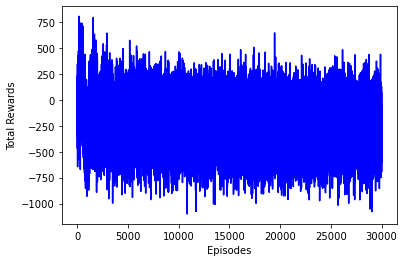

In [4]:
plt.plot(rewards, c='blue')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')

plt.show()

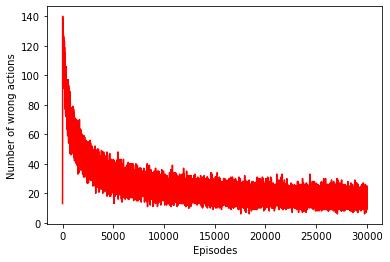

In [5]:
plt.plot(errors, c='red')
plt.xlabel('Episodes')
plt.ylabel('Number of wrong actions')
           
plt.show()

### After the fix.

In [9]:
for i in range(200):
    print('Current state: ', state_action_pairs[-i][0], ' Action will be taken: ', state_action_pairs[-i][1], 'chose a possible action: ', state_action_pairs[-i][2], 'chosen by chance: ', state_action_pairs[-i][3], ' All possible actions at that time: ', pos_actions_hist[-i])

Current state:  (1, 0, 0)  Action will be taken:  (1, 2) chose a possible action:  False chosen by chance:  True  All possible actions at that time:  [(4, 2), (0, 0), (0, 3), (1, 4), (3, 0), (2, 1), (4, 3), (4, 0), (2, 3), (1, 3), (3, 1)]
Current state:  (4, 19, 0)  Action will be taken:  (0, 0) chose a possible action:  True chosen by chance:  False  All possible actions at that time:  [(0, 0), (2, 3)]
Current state:  (1, 11, 0)  Action will be taken:  (3, 4) chose a possible action:  True chosen by chance:  False  All possible actions at that time:  [(0, 1), (3, 0), (1, 2), (4, 1), (0, 3), (2, 1), (1, 4), (4, 3), (3, 4), (4, 0), (2, 3), (1, 0), (4, 2), (2, 4), (1, 3)]
Current state:  (4, 8, 0)  Action will be taken:  (4, 1) chose a possible action:  True chosen by chance:  False  All possible actions at that time:  [(2, 0), (1, 3), (1, 0), (4, 1), (0, 0)]
Current state:  (4, 4, 0)  Action will be taken:  (3, 4) chose a possible action:  True chosen by chance:  False  All possible act

Current state:  (2, 2, 0)  Action will be taken:  (3, 1) chose a possible action:  True chosen by chance:  False  All possible actions at that time:  [(4, 3), (3, 1)]
Current state:  (4, 18, 0)  Action will be taken:  (3, 2) chose a possible action:  True chosen by chance:  False  All possible actions at that time:  [(3, 4), (2, 3), (3, 1), (3, 0), (2, 1), (4, 0), (1, 4), (1, 3), (0, 4), (3, 2), (0, 2), (1, 2)]
Current state:  (1, 10, 0)  Action will be taken:  (3, 4) chose a possible action:  True chosen by chance:  False  All possible actions at that time:  [(3, 0), (0, 4), (0, 2), (4, 2), (3, 1), (1, 2), (4, 3), (3, 4), (2, 3)]
Current state:  (2, 5, 0)  Action will be taken:  (4, 1) chose a possible action:  True chosen by chance:  False  All possible actions at that time:  [(4, 2), (4, 1)]
Current state:  (1, 0, 0)  Action will be taken:  (4, 2) chose a possible action:  True chosen by chance:  False  All possible actions at that time:  [(1, 4), (0, 3), (1, 0), (0, 1), (3, 2), (0,

## Saving the model.

In [7]:
from keras.models import model_from_json

model_json = agent.model.to_json()

with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
agent.model.save_weights('model.h5')